<a href="https://colab.research.google.com/github/joanats/classificador-gatos_cachorros/blob/main/Classificador_ML_gatos_cachorros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Classificador de Imagens com ML - Cachorros vs Gatos**

## **Objetivos do Desafio**

Este projeto tem como objetivo **desenvolver um modelo de machine learning** capaz de classificar imagens em duas categorias: gatos e cachorros. Para isso, utilizei técnicas de pré-processamento e Transfer Learning, reaproveitando uma rede neural convolucional previamente treinada para extrair características visuais das imagens e treinar um classificador específico para esse problema.

> Este notebook documenta o desenvolvimento, treinamento e análise do modelo, aplicando técnicas modernas de machine learning com foco em visão computacional.



## **Configurações Iniciais**

 Baixando o arquivo do desafio - O arquivo está hospedado no Google Drive e é acessado via o ID compartilhado

In [1]:
!gdown 1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB


Downloading...
From (original): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB
From (redirected): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB&confirm=t&uuid=9fa6e5b3-1d0c-48cf-9256-f1fd19ec1a18
To: /content/case_cats_and_dogs.zip
100% 573M/573M [00:02<00:00, 226MB/s]


Descompacta o arquivo 'case_cats_and_dogs.zip' que contém as imagens e o script train.py


In [2]:
!unzip case_cats_and_dogs

Archive:  case_cats_and_dogs.zip
replace case_cats_and_dogs/cats_and_dogs/class_cat/class1_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Excluindo o arquivo compactado

In [3]:
!rm -rf case_cats_and_dogs.zip

Importando as bibliotecas necessárias

In [4]:
!pip install pycaret

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
from pycaret.classification import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import base64
import random
import os

In [6]:
data_dir = "./case_cats_and_dogs/cats_and_dogs"

Definição dos caminhos das pastas de gatos e cachorros, utilizando a biblioteca `os`.

In [7]:
class_cat_dir = os.path.join(data_dir, "class_cat")
class_dog_dir = os.path.join(data_dir, "class_dog")

## **Treinamento do Modelo**

Neste projeto, utilizamos **Transfer Learning**, uma técnica que permite reaproveitar o conhecimento aprendido por uma rede neural treinada em um grande conjunto de dados (neste caso, o ImageNet), aplicando-o a um novo problema com um dataset menor.

A arquitetura escolhida foi a **VGG16**, fornecida pelo Keras. A linha abaixo carrega esse modelo com os seguintes parâmetros:

- `weights='imagenet'`: carrega os pesos treinados com o grande banco de dados ImageNet (com milhões de imagens em 1000 classes).
- `include_top=False`: remove as camadas densas finais responsáveis pela classificação original (1000 classes do ImageNet), permitindo que a gente adicione **nossas próprias camadas personalizadas** para o novo problema: classificar gatos e cachorros.

Este modelo passa então a atuar como um **extrator de características visuais** (features) das imagens, e as novas camadas finais que serão adicionadas posteriormente serão treinadas apenas com nosso conjunto de imagens.



Decidi utilizar a VGG16 pois é uma arquitetura **profundamente estudada e validada**, conhecida por sua **simplicidade** e **eficácia em tarefas de classificação de imagens**, me entregando como resultado a redução de treinamento e melhora da performace com poucos dados.

In [8]:
model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Agora criei a função `extract_features()` para processar uma imagem e extrair suas **características visuais (features)** usando a VGG16 pré-treinada.

Esse processo é fundamental no Transfer Learning, pois ao invés de treinar a rede do zero, aproveitamos a VGG16 como um **extrator de padrões visuais**, convertendo cada imagem em um vetor numérico (feature vector) que será usado por um classificador (como o PyCaret).


In [9]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

Limitei o número de imagens por classe para 1000 para balancear entre a diversidade dos dados e o tempo disponível para treino. Embora o dataset original contenha 25.000 imagens, usar todo o conjunto demandaria mais recursos computacionais e tempo.  
Essa quantidade permite **validar o modelo de forma eficiente**, podendo ser aumentada em etapas futuras para melhorar o desempenho.


In [10]:
MAX_IMAGES_PER_CLASS = 1000
X = []
y = []


Nesta etapa, percorremos a pasta de imagens da classe “gato” e extraímos as **features numéricas** de cada uma usando a função `extract_features()` baseada na VGG16.

Primeiro, listei apenas os arquivos válidos de imagem (.jpg, .jpeg, .png) e limitei a quantidade conforme o valor definido em `MAX_IMAGES_PER_CLASS`. Em seguida, cada imagem é processada individualmente, e seu vetor de características é armazenado na lista `X`, com o respectivo rótulo `0` (para a classe "gato") armazenado em `y`.

**Essa transformação permite que as imagens, que são dados visuais, sejam representadas numericamente e usadas por modelos de machine learning tradicionais.**


In [11]:
print("Processando imagens de gatos...")
cat_images = [img for img in os.listdir(class_cat_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
cat_images = cat_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(cat_images):
    img_path = os.path.join(class_cat_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(0)

Processando imagens de gatos...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 1/1000 [00:05<1:32:31,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  0%|          | 2/1000 [00:05<39:36,  2.38s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 3/1000 [00:05<22:36,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|          | 4/1000 [00:06<14:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  0%|          | 5/1000 [00:06<10:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  1%|          | 6/1000 [00:06<08:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  1%|          | 7/1000 [00:06<06:58,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  1%|          | 8/1000 [00:06<05:30,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  1%|          | 9/1000 [00:06<04:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  1%|          | 10/1000 [00:07<04:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  1%|          | 11/1000 [00:07<03:24,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|          | 12/1000 [00:07<03:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  1%|▏         | 13/1000 [00:07<03:25,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  1%|▏         | 14/1000 [00:07<03:19,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  2%|▏         | 15/1000 [00:08<03:09,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  2%|▏         | 16/1000 [00:08<03:06,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 17/1000 [00:08<02:51,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  2%|▏         | 18/1000 [00:08<02:39,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  2%|▏         | 19/1000 [00:08<02:39,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 20/1000 [00:08<02:46,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  2%|▏         | 21/1000 [00:09<03:16,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  2%|▏         | 22/1000 [00:09<03:13,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 23/1000 [00:09<03:09,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|▏         | 24/1000 [00:09<03:36,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  2%|▎         | 25/1000 [00:10<03:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|▎         | 26/1000 [00:10<03:44,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  3%|▎         | 27/1000 [00:10<03:22,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 28/1000 [00:10<03:17,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  3%|▎         | 29/1000 [00:10<02:56,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  3%|▎         | 30/1000 [00:10<02:44,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  3%|▎         | 31/1000 [00:11<02:39,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  3%|▎         | 32/1000 [00:11<02:56,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  3%|▎         | 33/1000 [00:11<02:52,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  3%|▎         | 34/1000 [00:11<03:01,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|▎         | 35/1000 [00:11<02:39,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 37/1000 [00:11<02:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 38/1000 [00:12<02:00,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▍         | 39/1000 [00:12<01:57,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|▍         | 40/1000 [00:12<01:52,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▍         | 41/1000 [00:12<01:54,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 42/1000 [00:12<01:57,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|▍         | 43/1000 [00:12<01:52,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  4%|▍         | 44/1000 [00:12<01:55,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▍         | 45/1000 [00:12<01:59,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  5%|▍         | 46/1000 [00:13<01:58,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▍         | 47/1000 [00:13<01:53,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 48/1000 [00:13<01:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  5%|▍         | 49/1000 [00:13<01:57,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|▌         | 50/1000 [00:13<01:59,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▌         | 51/1000 [00:13<01:59,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  5%|▌         | 52/1000 [00:13<02:01,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  5%|▌         | 53/1000 [00:13<02:05,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 54/1000 [00:14<01:57,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 55/1000 [00:14<01:52,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 56/1000 [00:14<01:50,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 58/1000 [00:14<01:32, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 59/1000 [00:14<01:35,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 60/1000 [00:14<01:37,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 61/1000 [00:14<01:39,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▋         | 63/1000 [00:14<01:36,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 65/1000 [00:15<01:26, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 67/1000 [00:15<01:27, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 69/1000 [00:15<01:26, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 71/1000 [00:15<01:26, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 73/1000 [00:15<01:25, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 75/1000 [00:16<01:26, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 77/1000 [00:16<01:31, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 79/1000 [00:16<01:28, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 81/1000 [00:16<01:26, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 83/1000 [00:16<01:21, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 85/1000 [00:16<01:22, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 87/1000 [00:17<01:24, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 89/1000 [00:17<01:24, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 91/1000 [00:17<01:20, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 93/1000 [00:17<01:16, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 95/1000 [00:17<01:22, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 97/1000 [00:18<01:22, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|▉         | 99/1000 [00:18<01:23, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 101/1000 [00:18<01:18, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 103/1000 [00:18<01:15, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 105/1000 [00:18<01:16, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 107/1000 [00:18<01:14, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 109/1000 [00:19<01:21, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 111/1000 [00:19<01:17, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█▏        | 113/1000 [00:19<01:22, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 115/1000 [00:19<01:18, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 117/1000 [00:19<01:19, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 119/1000 [00:19<01:21, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 121/1000 [00:20<01:22, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 123/1000 [00:20<01:21, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▎        | 125/1000 [00:20<01:21, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 127/1000 [00:20<01:21, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 129/1000 [00:20<01:24, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 131/1000 [00:21<01:20, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 133/1000 [00:21<01:17, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▎        | 135/1000 [00:21<01:21, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 137/1000 [00:21<01:20, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 139/1000 [00:21<01:19, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 141/1000 [00:22<01:19, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 143/1000 [00:22<01:24, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 145/1000 [00:22<01:22, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 147/1000 [00:22<01:24, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 149/1000 [00:22<01:25,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 150/1000 [00:22<01:26,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 151/1000 [00:23<01:27,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▌        | 152/1000 [00:23<01:27,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 154/1000 [00:23<01:18, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 156/1000 [00:23<01:14, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 158/1000 [00:23<01:19, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 160/1000 [00:23<01:18, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 162/1000 [00:24<01:18, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▋        | 164/1000 [00:24<01:26,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▋        | 165/1000 [00:24<01:30,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 167/1000 [00:24<01:27,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 169/1000 [00:24<01:25,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 17%|█▋        | 170/1000 [00:24<01:29,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 171/1000 [00:25<01:27,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 172/1000 [00:25<01:31,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 173/1000 [00:25<01:37,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 174/1000 [00:25<01:38,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 175/1000 [00:25<01:40,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 176/1000 [00:25<01:41,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 177/1000 [00:25<01:43,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 18%|█▊        | 178/1000 [00:25<01:44,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 18%|█▊        | 179/1000 [00:26<01:42,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 181/1000 [00:26<01:31,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 182/1000 [00:26<01:32,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 184/1000 [00:26<01:24,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 186/1000 [00:26<01:20, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▊        | 187/1000 [00:26<01:23,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 189/1000 [00:27<01:15, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 191/1000 [00:27<01:12, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 193/1000 [00:27<01:14, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|█▉        | 195/1000 [00:27<01:17, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|█▉        | 197/1000 [00:27<01:25,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|█▉        | 198/1000 [00:28<01:28,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 199/1000 [00:28<01:32,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 201/1000 [00:28<01:26,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 203/1000 [00:28<01:19,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 204/1000 [00:28<01:21,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 206/1000 [00:28<01:17, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 208/1000 [00:28<01:16, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 210/1000 [00:29<01:14, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 212/1000 [00:29<01:13, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 214/1000 [00:29<01:11, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 216/1000 [00:29<01:08, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 218/1000 [00:29<01:10, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 220/1000 [00:30<01:13, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 222/1000 [00:30<01:12, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 224/1000 [00:30<01:13, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 226/1000 [00:30<01:13, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 228/1000 [00:30<01:10, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 230/1000 [00:30<01:10, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 232/1000 [00:31<01:10, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 234/1000 [00:31<01:10, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▎       | 236/1000 [00:31<01:11, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 238/1000 [00:31<01:10, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 240/1000 [00:31<01:11, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 242/1000 [00:32<01:14, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 244/1000 [00:32<01:10, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 246/1000 [00:32<01:07, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 248/1000 [00:32<01:06, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 250/1000 [00:32<01:07, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 252/1000 [00:33<01:08, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 254/1000 [00:33<01:09, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 256/1000 [00:33<01:13, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 258/1000 [00:33<01:13, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 260/1000 [00:33<01:12, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 262/1000 [00:34<01:11, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▋       | 264/1000 [00:34<01:10, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 266/1000 [00:34<01:13, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 268/1000 [00:34<01:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 269/1000 [00:34<01:17,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 270/1000 [00:34<01:18,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 272/1000 [00:35<01:12, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 274/1000 [00:35<01:07, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 276/1000 [00:35<01:09, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 278/1000 [00:35<01:12,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██▊       | 280/1000 [00:35<01:08, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 282/1000 [00:36<01:11,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 28%|██▊       | 284/1000 [00:36<01:18,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 28%|██▊       | 285/1000 [00:36<01:21,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▊       | 286/1000 [00:36<01:22,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 29%|██▊       | 287/1000 [00:36<01:25,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 288/1000 [00:36<01:25,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 289/1000 [00:36<01:22,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 290/1000 [00:37<01:26,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▉       | 291/1000 [00:37<01:27,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▉       | 292/1000 [00:37<01:24,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 293/1000 [00:37<01:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 294/1000 [00:37<01:29,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|██▉       | 295/1000 [00:37<01:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 30%|██▉       | 296/1000 [00:37<01:34,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 297/1000 [00:37<01:34,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|██▉       | 298/1000 [00:38<01:30,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 30%|██▉       | 299/1000 [00:38<01:33,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 301/1000 [00:38<01:16,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 302/1000 [00:38<01:17,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 304/1000 [00:38<01:13,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 305/1000 [00:38<01:14,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 306/1000 [00:38<01:14,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 307/1000 [00:39<01:14,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 308/1000 [00:39<01:15,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 309/1000 [00:39<01:16,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 310/1000 [00:39<01:16,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 311/1000 [00:39<01:16,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 313/1000 [00:39<01:06, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 315/1000 [00:39<01:03, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 317/1000 [00:40<01:04, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 319/1000 [00:40<01:03, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 321/1000 [00:40<01:03, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 323/1000 [00:40<01:06, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▎      | 325/1000 [00:40<01:05, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 327/1000 [00:40<01:05, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 329/1000 [00:41<01:02, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 331/1000 [00:41<01:03, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 333/1000 [00:41<01:02, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▎      | 335/1000 [00:41<01:06, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▎      | 337/1000 [00:41<01:06, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 339/1000 [00:42<01:07,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 341/1000 [00:42<01:05, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 343/1000 [00:42<01:04, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 345/1000 [00:42<01:00, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 347/1000 [00:42<01:03, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 349/1000 [00:43<01:00, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 351/1000 [00:43<00:58, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 353/1000 [00:43<00:58, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 355/1000 [00:43<00:56, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 357/1000 [00:43<00:54, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 359/1000 [00:43<00:59, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 361/1000 [00:44<01:01, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 363/1000 [00:44<01:00, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 365/1000 [00:44<01:00, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 367/1000 [00:44<00:57, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 369/1000 [00:44<01:01, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 371/1000 [00:45<00:58, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 373/1000 [00:45<00:56, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 375/1000 [00:45<00:54, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 377/1000 [00:45<00:55, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 379/1000 [00:45<00:53, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 381/1000 [00:45<00:54, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 383/1000 [00:46<00:57, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 385/1000 [00:46<00:55, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▊      | 387/1000 [00:46<00:53, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 389/1000 [00:46<00:54, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 391/1000 [00:46<00:53, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 393/1000 [00:47<00:52, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███▉      | 395/1000 [00:47<00:52, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 397/1000 [00:47<00:53, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 399/1000 [00:47<00:57, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 401/1000 [00:47<00:53, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 403/1000 [00:47<00:56, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 405/1000 [00:48<01:01,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████      | 406/1000 [00:48<01:03,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████      | 407/1000 [00:48<01:07,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 408/1000 [00:48<01:09,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████      | 409/1000 [00:48<01:10,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 410/1000 [00:48<01:08,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 411/1000 [00:48<01:10,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 41%|████      | 412/1000 [00:49<01:12,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████▏     | 413/1000 [00:49<01:11,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████▏     | 414/1000 [00:49<01:12,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 415/1000 [00:49<01:10,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 416/1000 [00:49<01:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 417/1000 [00:49<01:09,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 418/1000 [00:49<01:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|████▏     | 419/1000 [00:49<01:13,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████▏     | 420/1000 [00:50<01:12,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 42%|████▏     | 421/1000 [00:50<01:16,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 422/1000 [00:50<01:13,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 423/1000 [00:50<01:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 424/1000 [00:50<01:10,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▎     | 425/1000 [00:50<01:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 427/1000 [00:50<01:01,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 429/1000 [00:51<00:55, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 431/1000 [00:51<00:58,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 432/1000 [00:51<00:59,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 433/1000 [00:51<01:01,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 434/1000 [00:51<01:01,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 435/1000 [00:51<01:01,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 437/1000 [00:51<00:58,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 438/1000 [00:52<00:58,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 439/1000 [00:52<00:59,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 440/1000 [00:52<01:00,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 441/1000 [00:52<01:01,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 442/1000 [00:52<01:01,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 443/1000 [00:52<01:01,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 445/1000 [00:52<00:53, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▍     | 447/1000 [00:52<00:53, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 449/1000 [00:53<00:55,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 450/1000 [00:53<00:57,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 452/1000 [00:53<00:55,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 453/1000 [00:53<00:56,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 454/1000 [00:53<00:56,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 455/1000 [00:53<00:58,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 456/1000 [00:54<01:43,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 458/1000 [00:54<01:18,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 459/1000 [00:54<01:14,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 460/1000 [00:54<01:10,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 462/1000 [00:54<01:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 463/1000 [00:54<01:02,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▋     | 465/1000 [00:55<00:54,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 467/1000 [00:55<00:52, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 469/1000 [00:55<00:50, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 471/1000 [00:55<00:50, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 473/1000 [00:55<00:52, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 475/1000 [00:56<00:51, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 477/1000 [00:56<00:52,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 479/1000 [00:56<00:51, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 481/1000 [00:56<00:52,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 482/1000 [00:56<00:53,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 483/1000 [00:56<00:54,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 485/1000 [00:57<00:49, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▊     | 487/1000 [00:57<00:46, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 489/1000 [00:57<00:47, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 491/1000 [00:57<00:47, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 493/1000 [00:57<00:48, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 495/1000 [00:58<00:50, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 497/1000 [00:58<00:52,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 498/1000 [00:58<00:52,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 499/1000 [00:58<00:52,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 501/1000 [00:58<00:51,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 503/1000 [00:58<00:50,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 504/1000 [00:58<00:51,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 506/1000 [00:59<00:49,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 507/1000 [00:59<00:50,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 509/1000 [00:59<00:49,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 510/1000 [00:59<00:50,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 512/1000 [00:59<00:48, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 514/1000 [00:59<00:47, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 516/1000 [01:00<00:48,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 517/1000 [01:00<00:49,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 52%|█████▏    | 519/1000 [01:00<00:47, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 520/1000 [01:00<00:50,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 521/1000 [01:00<00:50,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 52%|█████▏    | 522/1000 [01:00<00:53,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 523/1000 [01:00<00:54,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 524/1000 [01:01<00:56,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▎    | 525/1000 [01:01<00:57,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 526/1000 [01:01<00:58,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 527/1000 [01:01<00:55,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 53%|█████▎    | 528/1000 [01:01<00:57,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 529/1000 [01:01<00:59,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 530/1000 [01:01<00:59,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 531/1000 [01:01<00:59,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 532/1000 [01:02<00:59,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 533/1000 [01:02<00:56,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 534/1000 [01:02<00:58,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▎    | 535/1000 [01:02<00:59,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 54%|█████▎    | 536/1000 [01:02<01:01,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 537/1000 [01:02<01:00,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 539/1000 [01:02<00:52,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 540/1000 [01:03<00:52,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 541/1000 [01:03<00:51,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 543/1000 [01:03<00:48,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 544/1000 [01:03<00:49,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 545/1000 [01:03<00:49,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 547/1000 [01:03<00:48,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 548/1000 [01:03<00:48,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 549/1000 [01:04<00:48,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 551/1000 [01:04<00:43, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 553/1000 [01:04<00:43, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 555/1000 [01:04<00:44, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 557/1000 [01:04<00:45,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 559/1000 [01:04<00:44, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 561/1000 [01:05<00:41, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 563/1000 [01:05<00:39, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▋    | 565/1000 [01:05<00:40, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 567/1000 [01:05<00:39, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 569/1000 [01:05<00:41, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 571/1000 [01:06<00:43,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 573/1000 [01:06<00:44,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 574/1000 [01:06<00:44,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▊    | 575/1000 [01:06<00:45,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 576/1000 [01:06<00:45,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 577/1000 [01:06<00:46,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 578/1000 [01:06<00:46,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 580/1000 [01:07<00:43,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 581/1000 [01:07<00:44,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 583/1000 [01:07<00:42,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 584/1000 [01:07<00:43,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 586/1000 [01:07<00:41,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▊    | 587/1000 [01:07<00:42,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 588/1000 [01:07<00:43,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 589/1000 [01:08<00:43,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 590/1000 [01:08<00:44,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 591/1000 [01:08<00:44,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 592/1000 [01:08<00:44,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 593/1000 [01:08<00:44,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 594/1000 [01:08<00:44,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 595/1000 [01:08<00:44,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 596/1000 [01:08<00:44,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 597/1000 [01:08<00:44,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 598/1000 [01:09<00:44,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 600/1000 [01:09<00:40,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 601/1000 [01:09<00:40,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 602/1000 [01:09<00:42,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 603/1000 [01:09<00:42,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 605/1000 [01:09<00:37, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 607/1000 [01:09<00:39,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 609/1000 [01:10<00:38, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 611/1000 [01:10<00:38, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████▏   | 613/1000 [01:10<00:37, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 615/1000 [01:10<00:37, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 617/1000 [01:10<00:38, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 619/1000 [01:11<00:35, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 621/1000 [01:11<00:37, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 623/1000 [01:11<00:38,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 624/1000 [01:11<00:38,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 626/1000 [01:11<00:37,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 627/1000 [01:11<00:38,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 628/1000 [01:12<00:38,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 629/1000 [01:12<00:39,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 630/1000 [01:12<00:39,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 632/1000 [01:12<00:36, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 633/1000 [01:12<00:36,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 635/1000 [01:12<00:35, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▎   | 636/1000 [01:12<00:39,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 64%|██████▎   | 637/1000 [01:13<00:42,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 638/1000 [01:13<00:42,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 639/1000 [01:13<00:44,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 640/1000 [01:13<00:44,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 641/1000 [01:13<00:42,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 642/1000 [01:13<00:40,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 643/1000 [01:13<00:39,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▍   | 644/1000 [01:13<00:41,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▍   | 645/1000 [01:13<00:42,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▍   | 646/1000 [01:14<00:44,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▍   | 647/1000 [01:14<00:45,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▍   | 648/1000 [01:14<00:43,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 649/1000 [01:14<00:44,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 650/1000 [01:14<00:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 65%|██████▌   | 651/1000 [01:14<00:46,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▌   | 652/1000 [01:14<00:47,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 654/1000 [01:15<00:39,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 655/1000 [01:15<00:39,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 657/1000 [01:15<00:36,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 658/1000 [01:15<00:37,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 660/1000 [01:15<00:35,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 661/1000 [01:15<00:36,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 662/1000 [01:15<00:36,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 664/1000 [01:16<00:35,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 666/1000 [01:16<00:32, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 67%|██████▋   | 668/1000 [01:16<00:36,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 67%|██████▋   | 669/1000 [01:16<00:52,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 670/1000 [01:17<00:51,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 672/1000 [01:17<00:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 674/1000 [01:17<00:37,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|██████▊   | 675/1000 [01:17<00:55,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 68%|██████▊   | 676/1000 [01:17<00:55,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 678/1000 [01:18<00:45,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 679/1000 [01:18<00:43,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 680/1000 [01:18<00:41,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 68%|██████▊   | 681/1000 [01:18<00:51,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 68%|██████▊   | 682/1000 [01:18<01:00,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 683/1000 [01:19<00:53,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 685/1000 [01:19<00:44,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▊   | 687/1000 [01:19<00:37,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 689/1000 [01:19<00:33,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 690/1000 [01:19<00:33,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 692/1000 [01:19<00:32,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 693/1000 [01:20<00:32,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 694/1000 [01:20<00:33,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 695/1000 [01:20<00:33,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 697/1000 [01:20<00:32,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 699/1000 [01:20<00:30,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 700/1000 [01:20<00:31,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 702/1000 [01:20<00:28, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 704/1000 [01:21<00:29,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 706/1000 [01:21<00:29,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 707/1000 [01:21<00:30,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 708/1000 [01:21<00:31,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 710/1000 [01:21<00:29,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 711/1000 [01:21<00:30,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 712/1000 [01:21<00:30,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 714/1000 [01:22<00:27, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 716/1000 [01:22<00:28, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 718/1000 [01:22<00:26, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 720/1000 [01:22<00:25, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 722/1000 [01:22<00:25, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 724/1000 [01:23<00:26, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 726/1000 [01:23<00:26, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 728/1000 [01:23<00:26, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 730/1000 [01:23<00:24, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 732/1000 [01:23<00:25, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 734/1000 [01:24<00:26, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▎  | 736/1000 [01:24<00:26, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 738/1000 [01:24<00:26, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 740/1000 [01:24<00:26,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 742/1000 [01:24<00:25, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 744/1000 [01:25<00:26,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 745/1000 [01:25<00:27,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 746/1000 [01:25<00:27,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 747/1000 [01:25<00:28,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▍  | 748/1000 [01:25<00:29,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▍  | 749/1000 [01:25<00:28,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 750/1000 [01:25<00:27,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 751/1000 [01:25<00:27,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 752/1000 [01:26<00:28,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 753/1000 [01:26<00:27,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|███████▌  | 754/1000 [01:26<00:29,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▌  | 755/1000 [01:26<00:29,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▌  | 756/1000 [01:26<00:31,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 757/1000 [01:26<00:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▌  | 758/1000 [01:26<00:31,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▌  | 759/1000 [01:26<00:31,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 760/1000 [01:27<00:31,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 76%|███████▌  | 761/1000 [01:27<00:32,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 762/1000 [01:27<00:29,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 763/1000 [01:27<00:28,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 765/1000 [01:27<00:26,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 767/1000 [01:27<00:24,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 769/1000 [01:28<00:24,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 770/1000 [01:28<00:24,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 771/1000 [01:28<00:24,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 772/1000 [01:28<00:24,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 773/1000 [01:28<00:26,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 774/1000 [01:28<00:26,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 775/1000 [01:28<00:26,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 777/1000 [01:28<00:22,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 778/1000 [01:29<00:23,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 779/1000 [01:29<00:23,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 780/1000 [01:29<00:24,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 781/1000 [01:29<00:24,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 782/1000 [01:29<00:24,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 784/1000 [01:29<00:23,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 785/1000 [01:29<00:23,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 786/1000 [01:29<00:23,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 788/1000 [01:30<00:22,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 790/1000 [01:30<00:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 792/1000 [01:30<00:20, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 794/1000 [01:30<00:21,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 796/1000 [01:30<00:19, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 798/1000 [01:31<00:20,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 800/1000 [01:31<00:20, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 802/1000 [01:31<00:20,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 803/1000 [01:31<00:20,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 805/1000 [01:31<00:20,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 807/1000 [01:32<00:19,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 809/1000 [01:32<00:18, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 811/1000 [01:32<00:18, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████▏ | 813/1000 [01:32<00:18, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 815/1000 [01:32<00:18,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 817/1000 [01:32<00:18,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 819/1000 [01:33<00:18,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 820/1000 [01:33<00:18,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 822/1000 [01:33<00:18,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 824/1000 [01:33<00:17, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 826/1000 [01:33<00:18,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 827/1000 [01:34<00:18,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 828/1000 [01:34<00:18,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 829/1000 [01:34<00:19,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 830/1000 [01:34<00:19,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 831/1000 [01:34<00:19,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 833/1000 [01:34<00:18,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 834/1000 [01:34<00:18,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 835/1000 [01:34<00:18,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▎ | 837/1000 [01:35<00:16, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▍ | 838/1000 [01:35<00:16,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 840/1000 [01:35<00:16,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 842/1000 [01:35<00:16,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 844/1000 [01:35<00:16,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 846/1000 [01:36<00:14, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 848/1000 [01:36<00:14, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 850/1000 [01:36<00:14, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 852/1000 [01:36<00:14, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 854/1000 [01:36<00:15,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 855/1000 [01:36<00:15,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 857/1000 [01:37<00:14, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 859/1000 [01:37<00:15,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 860/1000 [01:37<00:15,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▌ | 861/1000 [01:37<00:15,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 862/1000 [01:37<00:15,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 86%|████████▋ | 863/1000 [01:37<00:17,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▋ | 864/1000 [01:38<00:17,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▋ | 865/1000 [01:38<00:16,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 866/1000 [01:38<00:16,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 867/1000 [01:38<00:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 868/1000 [01:38<00:16,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 869/1000 [01:38<00:16,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 870/1000 [01:38<00:16,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 871/1000 [01:38<00:16,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 87%|████████▋ | 872/1000 [01:39<00:17,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 873/1000 [01:39<00:17,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 874/1000 [01:39<00:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 88%|████████▊ | 875/1000 [01:39<00:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 876/1000 [01:39<00:17,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 878/1000 [01:39<00:14,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 880/1000 [01:39<00:13,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 881/1000 [01:40<00:13,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 883/1000 [01:40<00:12,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 885/1000 [01:40<00:11,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▊ | 886/1000 [01:40<00:11,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 888/1000 [01:40<00:11,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 889/1000 [01:40<00:11,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 890/1000 [01:41<00:11,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 892/1000 [01:41<00:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 894/1000 [01:41<00:10, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 896/1000 [01:41<00:09, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 898/1000 [01:41<00:09, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 900/1000 [01:41<00:09, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 902/1000 [01:42<00:09, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 904/1000 [01:42<00:09,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 905/1000 [01:42<00:09,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 906/1000 [01:42<00:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 908/1000 [01:42<00:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 910/1000 [01:43<00:09,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 912/1000 [01:43<00:08, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████▏| 914/1000 [01:43<00:08,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 915/1000 [01:43<00:08,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 916/1000 [01:43<00:08,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 917/1000 [01:43<00:08,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 918/1000 [01:43<00:08,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 920/1000 [01:44<00:08,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 921/1000 [01:44<00:08,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 922/1000 [01:44<00:08,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 924/1000 [01:44<00:07,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 926/1000 [01:44<00:07, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 928/1000 [01:44<00:07, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 930/1000 [01:45<00:07,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 932/1000 [01:45<00:06,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 933/1000 [01:45<00:06,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 935/1000 [01:45<00:06,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 937/1000 [01:45<00:06, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 939/1000 [01:45<00:06,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 940/1000 [01:46<00:06,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▍| 941/1000 [01:46<00:06,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 942/1000 [01:46<00:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 943/1000 [01:46<00:06,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 945/1000 [01:46<00:05, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 947/1000 [01:46<00:05, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 949/1000 [01:46<00:04, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 951/1000 [01:47<00:04,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 952/1000 [01:47<00:05,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 953/1000 [01:47<00:05,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 955/1000 [01:47<00:04,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 956/1000 [01:47<00:04,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 957/1000 [01:47<00:04,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 959/1000 [01:48<00:04,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 961/1000 [01:48<00:04,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 962/1000 [01:48<00:03,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 964/1000 [01:48<00:03, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▋| 965/1000 [01:48<00:03,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 966/1000 [01:48<00:03,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 968/1000 [01:49<00:03,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 969/1000 [01:49<00:03,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 970/1000 [01:49<00:03,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 972/1000 [01:49<00:02,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 973/1000 [01:49<00:02,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 975/1000 [01:49<00:02,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 98%|█████████▊| 976/1000 [01:49<00:02,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 977/1000 [01:49<00:02,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 978/1000 [01:50<00:02,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 979/1000 [01:50<00:02,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 98%|█████████▊| 980/1000 [01:50<00:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 98%|█████████▊| 981/1000 [01:50<00:02,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 982/1000 [01:50<00:02,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 983/1000 [01:50<00:02,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 984/1000 [01:50<00:02,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▊| 986/1000 [01:51<00:01,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▊| 987/1000 [01:51<00:01,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 988/1000 [01:51<00:01,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 989/1000 [01:51<00:01,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 99%|█████████▉| 990/1000 [01:51<00:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 991/1000 [01:51<00:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 992/1000 [01:51<00:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 993/1000 [01:52<00:00,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 994/1000 [01:52<00:00,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 995/1000 [01:52<00:00,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 997/1000 [01:52<00:00,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 998/1000 [01:52<00:00,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 999/1000 [01:52<00:00,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


Assim como fiz com a classe "gato", agora percorremos a pasta contendo imagens de **cachorros** para extrair suas características visuais utilizando o modelo VGG16.

O processo segue a mesma lógica: listei os arquivos válidos, limitei a quantidade a `MAX_IMAGES_PER_CLASS` e extraí as features de cada imagem.

O vetor resultante é armazenado em `X` e o rótulo correspondente `1` (para a classe "cachorro") é adicionado à lista `y`.

In [12]:
print("\nProcessando imagens de cães...")
dog_images = [img for img in os.listdir(class_dog_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
dog_images = dog_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(dog_images):
    img_path = os.path.join(class_dog_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(1)


Processando imagens de cães...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 2/1000 [00:00<01:22, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 4/1000 [00:00<01:19, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 6/1000 [00:00<01:18, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 8/1000 [00:00<01:24, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 10/1000 [00:00<01:27, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 12/1000 [00:01<01:28, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▏         | 14/1000 [00:01<01:26, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 16/1000 [00:01<01:28, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 18/1000 [00:01<01:24, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 20/1000 [00:01<01:28, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 22/1000 [00:01<01:24, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 24/1000 [00:02<01:31, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 26/1000 [00:02<01:30, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 28/1000 [00:02<01:35, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 30/1000 [00:02<01:37,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 32/1000 [00:02<01:31, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 34/1000 [00:03<01:30, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 36/1000 [00:03<01:34, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 38/1000 [00:03<01:38,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 40/1000 [00:03<01:35, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 42/1000 [00:03<01:39,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 43/1000 [00:04<01:40,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 45/1000 [00:04<01:36,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▍         | 46/1000 [00:04<01:37,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 48/1000 [00:04<01:34, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 50/1000 [00:04<01:32, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 52/1000 [00:04<01:32, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 54/1000 [00:05<01:35,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 55/1000 [00:05<01:36,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 56/1000 [00:05<01:38,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 58/1000 [00:05<01:30, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 60/1000 [00:05<01:30, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 62/1000 [00:05<01:29, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▋         | 64/1000 [00:06<01:29, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 66/1000 [00:06<01:32, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 68/1000 [00:06<01:31, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 70/1000 [00:06<01:29, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 72/1000 [00:06<01:34,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 74/1000 [00:07<01:32,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 76/1000 [00:07<01:27, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 78/1000 [00:07<01:27, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 80/1000 [00:07<01:27, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 82/1000 [00:07<01:31, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 84/1000 [00:08<01:33,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 86/1000 [00:08<01:27, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 88/1000 [00:08<01:27, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 90/1000 [00:08<01:22, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 92/1000 [00:08<01:23, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 94/1000 [00:08<01:24, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 96/1000 [00:09<01:24, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 10%|▉         | 98/1000 [00:09<01:32,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 10%|▉         | 99/1000 [00:09<01:38,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|█         | 100/1000 [00:09<01:37,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 101/1000 [00:09<01:36,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|█         | 102/1000 [00:09<01:42,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|█         | 103/1000 [00:10<01:40,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|█         | 104/1000 [00:10<01:39,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|█         | 105/1000 [00:10<01:44,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 11%|█         | 106/1000 [00:10<01:49,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 107/1000 [00:10<01:44,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 108/1000 [00:10<01:41,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|█         | 109/1000 [00:10<01:47,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 11%|█         | 110/1000 [00:10<01:50,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 11%|█         | 111/1000 [00:10<01:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█         | 112/1000 [00:11<01:54,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█▏        | 113/1000 [00:11<01:50,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█▏        | 114/1000 [00:11<01:47,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 116/1000 [00:11<01:37,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 117/1000 [00:11<01:37,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 118/1000 [00:11<01:37,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 120/1000 [00:11<01:25, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 122/1000 [00:12<01:25, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 124/1000 [00:12<01:28,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 126/1000 [00:12<01:25, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 128/1000 [00:12<01:28,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 130/1000 [00:12<01:25, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 132/1000 [00:13<01:25, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 134/1000 [00:13<01:28,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 135/1000 [00:13<01:29,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▎        | 136/1000 [00:13<01:30,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 138/1000 [00:13<01:25, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 140/1000 [00:13<01:19, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 142/1000 [00:14<01:20, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 144/1000 [00:14<01:20, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 146/1000 [00:14<01:16, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 148/1000 [00:14<01:16, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 150/1000 [00:14<01:17, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 152/1000 [00:14<01:14, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 154/1000 [00:15<01:16, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|█▌        | 156/1000 [00:15<01:13, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 158/1000 [00:15<01:11, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 160/1000 [00:15<01:13, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 162/1000 [00:15<01:18, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▋        | 164/1000 [00:16<01:18, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 166/1000 [00:16<01:23, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 168/1000 [00:16<01:18, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 170/1000 [00:16<01:18, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 172/1000 [00:16<01:14, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 174/1000 [00:17<01:14, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 176/1000 [00:17<01:15, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 178/1000 [00:17<01:14, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 180/1000 [00:17<01:11, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 182/1000 [00:17<01:16, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 184/1000 [00:17<01:19, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 186/1000 [00:18<01:18, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 188/1000 [00:18<01:18, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 190/1000 [00:18<01:21,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 192/1000 [00:18<01:17, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 194/1000 [00:18<01:16, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 196/1000 [00:19<01:20, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 198/1000 [00:19<01:19, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 200/1000 [00:19<01:17, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 202/1000 [00:19<01:13, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 204/1000 [00:19<01:19,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 206/1000 [00:20<01:18, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|██        | 208/1000 [00:20<01:18, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 210/1000 [00:20<01:17, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 212/1000 [00:20<01:19,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 213/1000 [00:20<01:21,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 214/1000 [00:20<01:21,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 215/1000 [00:21<01:22,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 217/1000 [00:21<01:20,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 218/1000 [00:21<01:23,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|██▏       | 219/1000 [00:21<01:25,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|██▏       | 220/1000 [00:21<01:29,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 221/1000 [00:21<01:32,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 223/1000 [00:21<01:25,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 224/1000 [00:22<01:23,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▎       | 225/1000 [00:22<01:22,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 226/1000 [00:22<01:26,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 23%|██▎       | 227/1000 [00:22<01:34,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 228/1000 [00:22<01:30,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 229/1000 [00:22<01:27,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 230/1000 [00:22<01:30,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 231/1000 [00:22<01:34,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 232/1000 [00:23<01:36,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 233/1000 [00:23<01:38,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 23%|██▎       | 234/1000 [00:23<01:40,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▎       | 235/1000 [00:23<01:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 237/1000 [00:23<01:30,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 238/1000 [00:23<01:28,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 240/1000 [00:23<01:22,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 241/1000 [00:24<01:22,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 243/1000 [00:24<01:13, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 245/1000 [00:24<01:13, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 247/1000 [00:24<01:12, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 249/1000 [00:24<01:12, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 251/1000 [00:24<01:11, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 253/1000 [00:25<01:11, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 255/1000 [00:25<01:10, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 257/1000 [00:25<01:09, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 259/1000 [00:25<01:09, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 261/1000 [00:25<01:10, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▋       | 263/1000 [00:26<01:14,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▋       | 265/1000 [00:26<01:09, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 267/1000 [00:26<01:10, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 269/1000 [00:26<01:09, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 271/1000 [00:26<01:12, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 273/1000 [00:27<01:11, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 275/1000 [00:27<01:10, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 277/1000 [00:27<01:06, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 279/1000 [00:27<01:10, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 281/1000 [00:27<01:06, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 283/1000 [00:28<01:07, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 285/1000 [00:28<01:10, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▊       | 287/1000 [00:28<01:06, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 289/1000 [00:28<01:08, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 291/1000 [00:28<01:07, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 293/1000 [00:29<01:07, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 295/1000 [00:29<01:06, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 297/1000 [00:29<01:09, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 299/1000 [00:29<01:09, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 301/1000 [00:29<01:05, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 303/1000 [00:29<01:05, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 305/1000 [00:30<01:05, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 307/1000 [00:30<01:02, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|███       | 309/1000 [00:30<01:06, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|███       | 311/1000 [00:30<01:08,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███▏      | 313/1000 [00:30<01:09,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 315/1000 [00:31<01:05, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 317/1000 [00:31<01:02, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 319/1000 [00:31<01:05, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 321/1000 [00:31<01:07, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 323/1000 [00:31<01:06, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▎      | 325/1000 [00:32<01:05, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 327/1000 [00:32<01:04, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 329/1000 [00:32<01:07,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 33%|███▎      | 330/1000 [00:32<01:09,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 33%|███▎      | 331/1000 [00:32<01:18,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 33%|███▎      | 332/1000 [00:32<01:31,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 33%|███▎      | 333/1000 [00:33<01:35,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 33%|███▎      | 334/1000 [00:33<01:54,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 34%|███▎      | 335/1000 [00:33<02:14,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▎      | 336/1000 [00:34<02:49,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 34%|███▎      | 337/1000 [00:34<03:40,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 34%|███▍      | 338/1000 [00:34<03:42,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 34%|███▍      | 339/1000 [00:35<03:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 340/1000 [00:35<03:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 341/1000 [00:35<02:50,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 34%|███▍      | 342/1000 [00:35<02:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 34%|███▍      | 343/1000 [00:35<02:11,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 344/1000 [00:36<01:59,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 345/1000 [00:36<01:46,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 346/1000 [00:36<01:36,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 348/1000 [00:36<01:16,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 350/1000 [00:36<01:10,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 352/1000 [00:36<01:03, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 354/1000 [00:37<01:01, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 356/1000 [00:37<01:00, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 358/1000 [00:37<00:58, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 360/1000 [00:37<00:58, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 362/1000 [00:37<00:59, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▋      | 364/1000 [00:37<00:58, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 366/1000 [00:38<00:55, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 368/1000 [00:38<00:56, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 370/1000 [00:38<00:57, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 372/1000 [00:38<01:00, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 374/1000 [00:38<01:00, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 376/1000 [00:39<00:59, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 378/1000 [00:39<00:59, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 380/1000 [00:39<00:58, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 382/1000 [00:39<00:56, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 384/1000 [00:39<00:57, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▊      | 386/1000 [00:40<00:58, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 388/1000 [00:40<01:00, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 390/1000 [00:40<00:56, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 392/1000 [00:40<00:56, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 394/1000 [00:40<00:56, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 396/1000 [00:40<00:54, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███▉      | 398/1000 [00:41<00:55, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 400/1000 [00:41<00:53, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 402/1000 [00:41<00:55, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 404/1000 [00:41<00:53, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 406/1000 [00:41<00:55, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████      | 408/1000 [00:42<00:58, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 410/1000 [00:42<00:55, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 412/1000 [00:42<00:54, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████▏     | 414/1000 [00:42<00:56, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 416/1000 [00:42<00:58,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 418/1000 [00:43<00:58, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 420/1000 [00:43<00:58,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 422/1000 [00:43<00:58,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 424/1000 [00:43<00:54, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 426/1000 [00:43<00:52, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 428/1000 [00:43<00:50, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 430/1000 [00:44<00:52, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 432/1000 [00:44<00:53, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 434/1000 [00:44<00:53, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▎     | 436/1000 [00:44<00:55, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 438/1000 [00:44<00:57,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 440/1000 [00:45<00:53, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 442/1000 [00:45<00:56,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 444/1000 [00:45<00:53, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▍     | 446/1000 [00:45<00:53, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 448/1000 [00:45<00:53, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 45%|████▌     | 450/1000 [00:46<00:55,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▌     | 451/1000 [00:46<01:00,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 45%|████▌     | 452/1000 [00:46<01:02,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 45%|████▌     | 453/1000 [00:46<01:04,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▌     | 454/1000 [00:46<01:04,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 455/1000 [00:46<01:07,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▌     | 456/1000 [00:46<01:09,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 457/1000 [00:47<01:09,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 458/1000 [00:47<01:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 459/1000 [00:47<01:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 46%|████▌     | 460/1000 [00:47<01:10,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████▌     | 461/1000 [00:47<01:11,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 462/1000 [00:47<01:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▋     | 463/1000 [00:47<01:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▋     | 464/1000 [00:48<01:09,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▋     | 465/1000 [00:48<01:11,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 466/1000 [00:48<01:10,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 467/1000 [00:48<01:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 468/1000 [00:48<01:06,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 469/1000 [00:48<01:04,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 470/1000 [00:48<01:03,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 472/1000 [00:48<00:57,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 473/1000 [00:49<00:57,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 475/1000 [00:49<00:54,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 477/1000 [00:49<00:53,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 478/1000 [00:49<00:54,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 479/1000 [00:49<00:55,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 481/1000 [00:49<00:50, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 483/1000 [00:50<00:52,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 484/1000 [00:50<00:54,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 485/1000 [00:50<00:54,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▊     | 486/1000 [00:50<00:55,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 487/1000 [00:50<00:55,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 489/1000 [00:50<00:49, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 491/1000 [00:50<00:49, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 493/1000 [00:51<00:46, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 495/1000 [00:51<00:45, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 497/1000 [00:51<00:49, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 499/1000 [00:51<00:51,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 501/1000 [00:51<00:48, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 503/1000 [00:52<00:50,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 505/1000 [00:52<00:47, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 507/1000 [00:52<00:48, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 509/1000 [00:52<00:46, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 511/1000 [00:52<00:48, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 513/1000 [00:52<00:45, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 515/1000 [00:53<00:48,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 517/1000 [00:53<00:50,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 518/1000 [00:53<00:51,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 519/1000 [00:53<00:52,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 520/1000 [00:53<00:52,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 522/1000 [00:53<00:47, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 524/1000 [00:54<00:46, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 526/1000 [00:54<00:46, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 528/1000 [00:54<00:49,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 529/1000 [00:54<00:50,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 530/1000 [00:54<00:51,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 531/1000 [00:54<00:51,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 533/1000 [00:55<00:46, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 535/1000 [00:55<00:45, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 537/1000 [00:55<00:42, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 539/1000 [00:55<00:44, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 541/1000 [00:55<00:44, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 543/1000 [00:56<00:42, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 545/1000 [00:56<00:41, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 547/1000 [00:56<00:42, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▍    | 549/1000 [00:56<00:44, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 551/1000 [00:56<00:45,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 552/1000 [00:56<00:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 553/1000 [00:57<00:47,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 555/1000 [00:57<00:43, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 557/1000 [00:57<00:41, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 559/1000 [00:57<00:44, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 561/1000 [00:57<00:44,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 562/1000 [00:57<00:45,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 563/1000 [00:58<00:46,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▋    | 565/1000 [00:58<00:45,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 57%|█████▋    | 566/1000 [00:58<00:48,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 567/1000 [00:58<00:48,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 568/1000 [00:58<00:50,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 569/1000 [00:58<00:52,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 57%|█████▋    | 570/1000 [00:58<00:53,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 571/1000 [00:59<00:51,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 572/1000 [00:59<00:50,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 573/1000 [00:59<00:51,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 574/1000 [00:59<00:49,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▊    | 575/1000 [00:59<00:48,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 576/1000 [00:59<00:46,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 577/1000 [00:59<00:46,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 578/1000 [00:59<00:50,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 579/1000 [00:59<00:52,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 580/1000 [01:00<00:50,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 581/1000 [01:00<00:53,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 582/1000 [01:00<00:53,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 583/1000 [01:00<00:51,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 584/1000 [01:00<00:52,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▊    | 586/1000 [01:00<00:46,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▊    | 587/1000 [01:00<00:46,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 588/1000 [01:01<00:46,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 590/1000 [01:01<00:43,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 592/1000 [01:01<00:39, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 594/1000 [01:01<00:39, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 596/1000 [01:01<00:40,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 597/1000 [01:01<00:41,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 599/1000 [01:02<00:40,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 601/1000 [01:02<00:38, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 603/1000 [01:02<00:40,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 604/1000 [01:02<00:41,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 605/1000 [01:02<00:42,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 607/1000 [01:02<00:41,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 608/1000 [01:03<00:41,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 609/1000 [01:03<00:41,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 610/1000 [01:03<00:42,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 612/1000 [01:03<00:38, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 614/1000 [01:03<00:38, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 616/1000 [01:03<00:35, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 618/1000 [01:04<00:36, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 620/1000 [01:04<00:38,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 621/1000 [01:04<00:38,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 622/1000 [01:04<00:40,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 623/1000 [01:04<00:40,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 624/1000 [01:04<00:40,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▎   | 625/1000 [01:04<00:41,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 626/1000 [01:04<00:41,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 627/1000 [01:05<00:42,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 628/1000 [01:05<00:42,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 629/1000 [01:05<00:42,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 631/1000 [01:05<00:39,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 633/1000 [01:05<00:35, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 635/1000 [01:05<00:34, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 637/1000 [01:06<00:36,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 638/1000 [01:06<00:37,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 640/1000 [01:06<00:36,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 641/1000 [01:06<00:36,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 642/1000 [01:06<00:36,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 643/1000 [01:06<00:37,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 644/1000 [01:06<00:38,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 646/1000 [01:06<00:37,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▍   | 647/1000 [01:07<00:37,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 649/1000 [01:07<00:35,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 650/1000 [01:07<00:37,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 651/1000 [01:07<00:38,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▌   | 652/1000 [01:07<00:38,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 653/1000 [01:07<00:38,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 654/1000 [01:07<00:37,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 655/1000 [01:07<00:37,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 657/1000 [01:08<00:35,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 658/1000 [01:08<00:36,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 660/1000 [01:08<00:35,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 661/1000 [01:08<00:36,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 662/1000 [01:08<00:36,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 664/1000 [01:08<00:33, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 665/1000 [01:08<00:34,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 667/1000 [01:09<00:32, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 669/1000 [01:09<00:30, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 671/1000 [01:09<00:31, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 673/1000 [01:09<00:32,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 675/1000 [01:09<00:32, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 677/1000 [01:10<00:32, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 679/1000 [01:10<00:31, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 681/1000 [01:10<00:29, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 683/1000 [01:10<00:33,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 684/1000 [01:10<00:34,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 685/1000 [01:11<00:36,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 69%|██████▊   | 686/1000 [01:11<00:38,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|██████▊   | 687/1000 [01:11<00:38,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 688/1000 [01:11<00:37,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 689/1000 [01:11<00:38,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 690/1000 [01:11<00:36,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 691/1000 [01:11<00:36,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 692/1000 [01:11<00:37,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 693/1000 [01:12<00:36,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 69%|██████▉   | 694/1000 [01:12<00:36,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 70%|██████▉   | 695/1000 [01:12<00:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|██████▉   | 696/1000 [01:12<00:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|██████▉   | 697/1000 [01:12<00:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|██████▉   | 698/1000 [01:12<00:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|██████▉   | 699/1000 [01:12<00:39,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 700/1000 [01:12<00:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████   | 701/1000 [01:13<00:37,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|███████   | 703/1000 [01:13<00:33,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 704/1000 [01:13<00:33,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 706/1000 [01:13<00:32,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 708/1000 [01:13<00:30,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 709/1000 [01:13<00:30,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 710/1000 [01:14<00:31,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 711/1000 [01:14<00:31,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 712/1000 [01:14<00:31,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 713/1000 [01:14<00:32,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 714/1000 [01:14<00:32,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 716/1000 [01:14<00:30,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 717/1000 [01:14<00:30,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 719/1000 [01:14<00:28,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 720/1000 [01:15<00:29,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 722/1000 [01:15<00:27, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 723/1000 [01:15<00:28,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 724/1000 [01:15<00:29,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▎  | 725/1000 [01:15<00:30,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 727/1000 [01:15<00:28,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 729/1000 [01:15<00:27,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 730/1000 [01:16<00:28,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 731/1000 [01:16<00:29,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 733/1000 [01:16<00:29,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▎  | 735/1000 [01:16<00:26,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 736/1000 [01:16<00:27,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 738/1000 [01:16<00:26,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 739/1000 [01:17<00:26,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 740/1000 [01:17<00:27,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 742/1000 [01:17<00:25, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 744/1000 [01:17<00:26,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 745/1000 [01:17<00:27,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 747/1000 [01:17<00:26,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 749/1000 [01:18<00:25,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 751/1000 [01:18<00:23, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 753/1000 [01:18<00:24,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 755/1000 [01:18<00:23, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 757/1000 [01:18<00:23, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 759/1000 [01:19<00:23, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 761/1000 [01:19<00:23, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▋  | 763/1000 [01:19<00:22, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 765/1000 [01:19<00:22, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 767/1000 [01:19<00:22, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 769/1000 [01:19<00:21, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 771/1000 [01:20<00:21, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 773/1000 [01:20<00:23,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 774/1000 [01:20<00:23,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 775/1000 [01:20<00:23,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 776/1000 [01:20<00:23,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 777/1000 [01:20<00:24,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 778/1000 [01:20<00:24,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 779/1000 [01:21<00:24,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 780/1000 [01:21<00:24,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 782/1000 [01:21<00:22,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 783/1000 [01:21<00:22,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 784/1000 [01:21<00:23,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 785/1000 [01:21<00:23,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 786/1000 [01:21<00:23,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 788/1000 [01:21<00:20, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 789/1000 [01:22<00:21,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 791/1000 [01:22<00:21,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 793/1000 [01:22<00:19, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 795/1000 [01:22<00:21,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 797/1000 [01:22<00:19, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 80%|███████▉  | 799/1000 [01:23<00:21,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|████████  | 800/1000 [01:23<00:22,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|████████  | 801/1000 [01:23<00:22,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|████████  | 802/1000 [01:23<00:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|████████  | 803/1000 [01:23<00:24,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 80%|████████  | 804/1000 [01:23<00:24,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|████████  | 805/1000 [01:23<00:25,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 81%|████████  | 806/1000 [01:24<00:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 807/1000 [01:24<00:24,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 808/1000 [01:24<00:24,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 809/1000 [01:24<00:25,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 810/1000 [01:24<00:24,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 811/1000 [01:24<00:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 81%|████████  | 812/1000 [01:24<00:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████▏ | 813/1000 [01:25<00:25,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████▏ | 814/1000 [01:25<00:25,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 815/1000 [01:25<00:23,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 817/1000 [01:25<00:19,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 819/1000 [01:25<00:18,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 820/1000 [01:25<00:19,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 821/1000 [01:25<00:19,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 823/1000 [01:26<00:17, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 824/1000 [01:26<00:17,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 826/1000 [01:26<00:17,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 827/1000 [01:26<00:18,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 829/1000 [01:26<00:16, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 830/1000 [01:26<00:17,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 832/1000 [01:26<00:16, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 834/1000 [01:27<00:16, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 836/1000 [01:27<00:15, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 838/1000 [01:27<00:15, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 840/1000 [01:27<00:14, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 842/1000 [01:27<00:15,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 844/1000 [01:28<00:15, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 846/1000 [01:28<00:15, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 848/1000 [01:28<00:15,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 849/1000 [01:28<00:15,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 850/1000 [01:28<00:15,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 852/1000 [01:28<00:15,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 854/1000 [01:29<00:15,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 855/1000 [01:29<00:15,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 857/1000 [01:29<00:14,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 858/1000 [01:29<00:14,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 859/1000 [01:29<00:15,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 861/1000 [01:29<00:14,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 862/1000 [01:29<00:14,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 863/1000 [01:30<00:14,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 865/1000 [01:30<00:14,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 866/1000 [01:30<00:14,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 868/1000 [01:30<00:13,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 870/1000 [01:30<00:13,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 871/1000 [01:30<00:13,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 873/1000 [01:31<00:12,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 875/1000 [01:31<00:12,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 877/1000 [01:31<00:12,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 879/1000 [01:31<00:11, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 881/1000 [01:31<00:12,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 882/1000 [01:32<00:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 883/1000 [01:32<00:12,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 884/1000 [01:32<00:12,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 886/1000 [01:32<00:11,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 888/1000 [01:32<00:11,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 889/1000 [01:32<00:11,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 890/1000 [01:32<00:11,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 891/1000 [01:33<00:12,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 893/1000 [01:33<00:11,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 894/1000 [01:33<00:11,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 895/1000 [01:33<00:11,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 896/1000 [01:33<00:11,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 897/1000 [01:33<00:11,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 898/1000 [01:33<00:11,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 899/1000 [01:33<00:11,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 900/1000 [01:34<00:11,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 902/1000 [01:34<00:10,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|█████████ | 904/1000 [01:34<00:09, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 905/1000 [01:34<00:09,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 907/1000 [01:34<00:08, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 909/1000 [01:34<00:08, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 911/1000 [01:35<00:08, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████▏| 913/1000 [01:35<00:09,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████▏| 914/1000 [01:35<00:09,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 915/1000 [01:35<00:09,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 916/1000 [01:35<00:09,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 917/1000 [01:35<00:09,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 92%|█████████▏| 918/1000 [01:35<00:09,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 919/1000 [01:36<00:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 920/1000 [01:36<00:10,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 921/1000 [01:36<00:10,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|█████████▏| 922/1000 [01:36<00:10,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 923/1000 [01:36<00:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 924/1000 [01:36<00:10,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 92%|█████████▎| 925/1000 [01:36<00:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 93%|█████████▎| 926/1000 [01:37<00:09,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 927/1000 [01:37<00:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████▎| 928/1000 [01:37<00:09,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 929/1000 [01:37<00:09,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 930/1000 [01:37<00:09,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 931/1000 [01:37<00:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 933/1000 [01:37<00:07,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 934/1000 [01:38<00:07,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▎| 935/1000 [01:38<00:07,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▎| 937/1000 [01:38<00:07,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 939/1000 [01:38<00:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 940/1000 [01:38<00:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 941/1000 [01:38<00:06,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 943/1000 [01:38<00:06,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 944/1000 [01:39<00:06,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|█████████▍| 945/1000 [01:39<00:06,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 946/1000 [01:39<00:06,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 948/1000 [01:39<00:05,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 950/1000 [01:39<00:04, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 952/1000 [01:39<00:04, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 954/1000 [01:40<00:04, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 956/1000 [01:40<00:04,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 957/1000 [01:40<00:04,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 959/1000 [01:40<00:04,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 960/1000 [01:40<00:04,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 961/1000 [01:40<00:04,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 963/1000 [01:41<00:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 964/1000 [01:41<00:03,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 966/1000 [01:41<00:03,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 968/1000 [01:41<00:03,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 969/1000 [01:41<00:03,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 971/1000 [01:41<00:02,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 972/1000 [01:41<00:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 973/1000 [01:42<00:02,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 975/1000 [01:42<00:02,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 976/1000 [01:42<00:02,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 977/1000 [01:42<00:02,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 978/1000 [01:42<00:02,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 980/1000 [01:42<00:01, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 982/1000 [01:42<00:01,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 983/1000 [01:43<00:01,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 984/1000 [01:43<00:01,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 985/1000 [01:43<00:01,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 986/1000 [01:43<00:01,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 988/1000 [01:43<00:01,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 989/1000 [01:43<00:01,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 990/1000 [01:43<00:01,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 991/1000 [01:43<00:00,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 993/1000 [01:44<00:00, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 995/1000 [01:44<00:00,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████▉| 997/1000 [01:44<00:00,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 998/1000 [01:44<00:00,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 999/1000 [01:44<00:00,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


Depois de extrair as features e os rótulos de todas as imagens, **eu converto as listas `X` e `y` para arrays NumPy**. Faço isso porque as bibliotecas de machine learning que vou usar (como scikit-learn e PyCaret) exigem os dados nesse formato para funcionar corretamente.

In [13]:
X = np.array(X)
y = np.array(y)

Imprimo na tela o total de imagens que extraí as features, mostrando também a quantidade aproximada por classe (gatos e cachorros), para garantir que a extração foi feita corretamente e que as classes estão balanceadas.

In [14]:
print(f"\nTotal de imagens processadas: {len(X)} ({(len(X)/2)} de cada classe)")


Total de imagens processadas: 2000 (1000.0 de cada classe)


Criando um DataFrame com as features extraídas e adicionando uma coluna com os rótulos (target) para facilitar a análise e manipulação dos dados, utilizando a biblioteca pandas.


In [15]:
features_df = pd.DataFrame(X)
features_df['target'] = y

## **Machine Learning (Modelagem e Avaliação)**

Configurando o ambiente do PyCaret para classificação, informando os dados (`features_df`), a coluna de rótulo (`target`), a proporção de treino (80%) e um `session_id` fixo para garantir reprodutibilidade.

Escolhi utilizar a biblioteca PyCaret pois ela permite ir desde a preparação dos dados até a implementação do modelo em minutos.
A principal vantagem de usar essa abordagem aqui é que o Pycaret pode treinar e testar 20 tipos diferentes de modelos, utilizando a abordagem AutoML.


In [16]:
clf1 = setup(data=features_df,
             target='target',
             train_size=0.8,
             session_id=42,
             verbose=False)

Agora eu chamo a função `compare_models()`, que **avalia automaticamente diversos algoritmos de classificação e apresenta os melhores resultados**.

Para tornar o processo mais rápido e eficiente, eu especifiquei o parâmetro `include` com os modelos principais que quero testar:
- regressão logística (`lr`)
- SVM, ridge, random forest (`rf`)
- AdaBoost (`ada`)
- Naive Bayes (`nb`)
- árvore de decisão (`dt`)
- KNN.

Assim, o PyCaret foca nesses algoritmos, **reduzindo o tempo de processamento e facilitando a comparação.**


In [17]:
compare_models(include=['lr', 'svm', 'ridge', 'rf', 'ada', 'nb', 'dt', 'knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9806,0.9971,0.9762,0.9852,0.9804,0.9612,0.9618,7.3450
svm,SVM - Linear Kernel,0.9688,0.9957,0.9588,0.9786,0.9684,0.9375,0.9381,5.8970
rf,Random Forest Classifier,0.9675,0.9941,0.9788,0.9576,0.9679,0.9350,0.9355,8.2440
ridge,Ridge Classifier,0.9638,0.9949,0.9500,0.9775,0.9631,0.9275,0.9287,6.5600
ada,Ada Boost Classifier,0.9600,0.9913,0.9612,0.9592,0.9600,0.9200,0.9204,37.5900
nb,Naive Bayes,0.9450,0.9498,0.9438,0.9466,0.9449,0.8900,0.8906,5.7860
dt,Decision Tree Classifier,0.8688,0.8688,0.8600,0.8765,0.8677,0.7375,0.7383,11.9760
knn,K Neighbors Classifier,0.8369,0.9276,0.7388,0.9197,0.8166,0.6738,0.6893,6.4320


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Como podemos ver, o **Logistic Regression (Regressão Logística) obteve o melhor desempenho** entre os demais modelos testados.

**A regressão logística** é um modelo estatístico bastante utilizado para problemas de classificação binária, pois estima a probabilidade de uma observação pertencer a uma determinada classe. Além disso, é simples, eficiente e interpreta bem os efeitos das variáveis preditoras.

Esse resultado indica que, para o nosso conjunto de dados, **a regressão logística conseguiu capturar melhor** as relações entre as variáveis e a classe alvo, apresentando maior precisão e generalização em comparação aos outros algoritmos avaliados.



É importante mencionar que o PyCaret utiliza técnicas para **reduzir o overfitting**, como validação cruzada e ajuste de hiperparâmetros, garantindo uma melhor generalização dos modelos aos dados novos.

Dito isso, criamos um modelo de regressão logística (`lr`).

In [18]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9875,0.9995,0.9750,1.0000,0.9873,0.9750,0.9753
1,0.9812,0.9980,0.9750,0.9873,0.9811,0.9625,0.9626
2,0.9625,0.9964,0.9250,1.0000,0.9610,0.9250,0.9276
3,0.9812,0.9908,1.0000,0.9639,0.9816,0.9625,0.9632
4,0.9750,0.9994,0.9500,1.0000,0.9744,0.9500,0.9512
5,0.9688,0.9977,0.9625,0.9747,0.9686,0.9375,0.9376
6,0.9750,0.9973,0.9875,0.9634,0.9753,0.9500,0.9503
7,0.9812,0.9920,0.9875,0.9753,0.9814,0.9625,0.9626
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Agora iremos ajustar (tunar) o modelo para melhorar seu desempenho antes da validação final.



In [19]:
tuned_lr = tune_model(lr_model)
print(tuned_lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9875,0.9995,0.9750,1.0000,0.9873,0.9750,0.9753
1,0.9812,0.9980,0.9750,0.9873,0.9811,0.9625,0.9626
2,0.9625,0.9964,0.9250,1.0000,0.9610,0.9250,0.9276
3,0.9812,0.9908,1.0000,0.9639,0.9816,0.9625,0.9632
4,0.9750,0.9994,0.9500,1.0000,0.9744,0.9500,0.9512
5,0.9688,0.9977,0.9625,0.9747,0.9686,0.9375,0.9376
6,0.9750,0.9973,0.9875,0.9634,0.9753,0.9500,0.9503
7,0.9812,0.9920,0.9875,0.9753,0.9814,0.9625,0.9626
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Após o ajuste de hiperparâmetros com a função tune_model( ), o PyCaret identificou que o **modelo original apresentou desempenho superior ao modelo ajustado.** Por isso, o modelo original foi mantido como final.

Finalizamos o modelo de **Regressão Logística** com a função finalize_model( ), que prepara o modelo para produção, utilizando os parâmetros e estrutura obtidos durante o treinamento. **Como o modelo original teve melhor desempenho do que o modelo ajustado, ele foi mantido e finalizado**

In [20]:
final_lr = finalize_model(lr_model)

Agora que o modelo foi finalizado, podemos criar uma função para utilizá-lo em previsões de novas imagens.

O que faço dentro da função:

- Extraio as features da imagem usando a função `extract_features()`, que utiliza a VGG16 pré-treinada.
- Crio um DataFrame com essas features, para ser compatível com o PyCaret.
- Uso a função `predict_model()` do PyCaret para fazer a previsão com o modelo final treinado (`final_lr`).
- Traduzo o resultado numérico para o rótulo “gato” ou “cachorro”.
- Retorno uma mensagem formatada com o resultado e a porcentagem de confiança.

In [21]:
def classify_new_image(image_path):

    features = extract_features(image_path)
    new_data = pd.DataFrame([features])
    prediction = predict_model(final_lr, data=new_data)


    class_label = "gato" if prediction['prediction_label'][0] == 0 else "cachorro"
    confidence = prediction['prediction_score'][0]

    return f"A imagem é de um {class_label} (confiança: {confidence:.2%})"

Aqui eu seleciono um número limitado de imagens aleatórias de cada classe (gatos e cachorros), para garantir variedade sem precisar processar todo o conjunto.

Depois, classifico cada uma dessas imagens usando a função `classify_new_image()`. Armazeno os resultados em listas separadas e imprimo o nome da imagem junto com a previsão.

Por fim, mostro alguns exemplos das classificações feitas para cada classe, para observar como o modelo está performando na prática.



In [22]:
def select_random_images(class_dir, num_images=20):
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(images, min(num_images, len(images)))


cat_images = select_random_images(class_cat_dir)
dog_images = select_random_images(class_dog_dir)


print("Classificando imagens de gatos:")
cat_results = []
for img_name in cat_images:
    img_path = os.path.join(class_cat_dir, img_name)
    result = classify_new_image(img_path)
    cat_results.append((img_name, result))
    print(f"{img_name}: {result}")


print("\nClassificando imagens de cachorros:")
dog_results = []
for img_name in dog_images:
    img_path = os.path.join(class_dog_dir, img_name)
    result = classify_new_image(img_path)
    dog_results.append((img_name, result))
    print(f"{img_name}: {result}")



print("\nExemplos de classificações:")
print("\nGatos:")
for img, res in cat_results[:3]:
    print(f"{img}: {res}")

print("\nCachorros:")
for img, res in dog_results[:3]:
    print(f"{img}: {res}")

Classificando imagens de gatos:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


class1_2264.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_11697.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_8318.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


class1_2040.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_801.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_5760.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


class1_4350.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_2544.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_11660.jpg: A imagem é de um gato (confiança: 89.05%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_11499.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


class1_5408.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_4135.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_9347.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


class1_11970.jpg: A imagem é de um gato (confiança: 98.73%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_7198.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_8753.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class1_1072.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_7997.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_12466.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class1_6524.jpg: A imagem é de um gato (confiança: 100.00%)

Classificando imagens de cachorros:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


class2_3984.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


class2_12342.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class2_11150.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


class2_7075.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


class2_9087.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_5516.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class2_9009.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


class2_2452.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_6938.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


class2_6018.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


class2_699.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_5074.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_2316.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


class2_3649.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


class2_10650.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


class2_8229.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_12075.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class2_8682.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


class2_1298.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


class2_5660.jpg: A imagem é de um cachorro (confiança: 100.00%)

Exemplos de classificações:

Gatos:
class1_2264.jpg: A imagem é de um gato (confiança: 100.00%)
class1_11697.jpg: A imagem é de um gato (confiança: 100.00%)
class1_8318.jpg: A imagem é de um gato (confiança: 100.00%)

Cachorros:
class2_3984.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_12342.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_11150.jpg: A imagem é de um cachorro (confiança: 100.00%)


Os resultados acima já são bem satisfatórios, porém, decidi **criar uma função para exibir algumas imagens** junto com a classificação que o modelo deu pra cada um.

Para isso, crio a função `show_imagens_with_labels`, que recebe os resultados das classificações, o caminho da pasta das imagens e a quantidade de imagens que quero guardar.

Para cada imagem, ela lê o arquivo, exibe a imagem e coloca um título com o rótulo previsto: “Gato”, “Cachorro” ou “Desconhecido” caso o resultado não seja claro.

**Uso essa função para mostrar as primeiras imagens classificadas de gatos e cachorros, facilitando a visualização dos acertos e possíveis erros.**


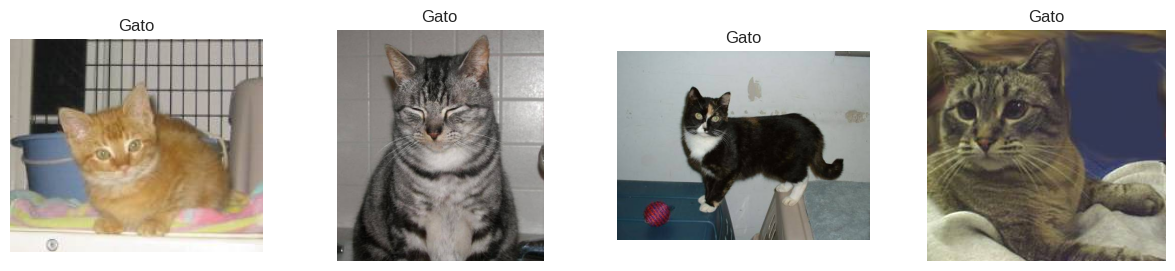

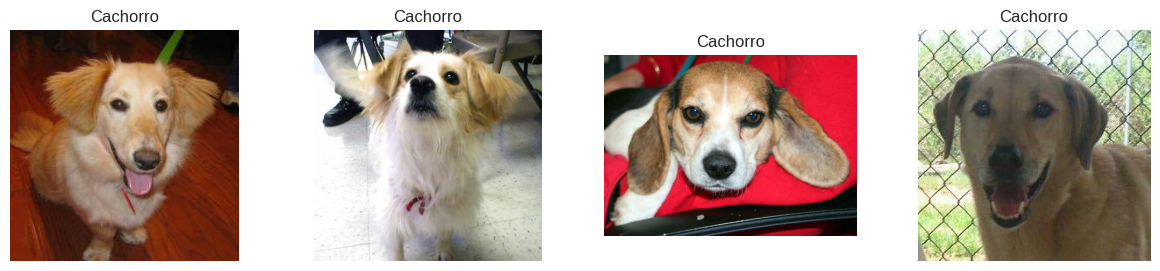

In [23]:
def show_images_with_labels(results, class_dir, num_images=6):
    plt.figure(figsize=(15, 3))
    for i, (img_name, result) in enumerate(results[:num_images]):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)


        result_lower = result.lower()
        if 'gato' in result_lower:
            title = 'Gato'
        elif 'cachorro' in result_lower:
            title = 'Cachorro'
        else:
            title = 'Desconhecido'

        plt.title(title)
        plt.axis('off')
    plt.show()


show_images_with_labels(cat_results, class_cat_dir, num_images=4)
show_images_with_labels(dog_results, class_dog_dir, num_images=4)


Como podemos ver, as imagens apresentadas foram **classificadas pelo modelo com sucesso**, mostrando uma boa capacidade de distinguir entre gatos e cachorros.

Dentre os modelos avaliados no PyCaret, a Regressão Logística obteve os melhores resultados, com média de:

- **Accuracy:** 0.9806

- **AUC:** 0.9971

- **Recall:** 0.9762

- **Precision:** 0.9852

- **F1-score:** 0.9804

Essas métricas indicam que o modelo apresenta alta precisão e capacidade de generalização, com baixo risco de overfitting — especialmente considerando que o PyCaret aplica técnicas como validação cruzada e ajuste de hiperparâmetros durante o treinamento.



Agora, vamos salvar o modelo, concluindo esta etapa do projeto!

In [24]:
save_model(final_lr, 'melhor_modelo_gatos_cachorros')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                                                               fill_value=None,
                                                     

## **Obrigada!**

Obrigada por acompanhar! Todo o processo de construir esse modelo e aprender as técnicas envolvidas foi super enriquecedor pra mim. Aprendi muita coisa nova que com certeza vai ajudar na minha carreira profissional.

[![Gmail](https://img.shields.io/badge/Gmail-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:joanatrindade58@gmail.com)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/joanatrindade-)

    
Made with ❤️ by Joana Trindade.

## **Referências**



[1] [TensorFlow / Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)  

[2] [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[3] [PyCaret](https://pycaret.org/classification/)

[4] [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)  

[5] [tqdm](https://tqdm.github.io/)  

[6] [pandas](https://pandas.pydata.org/docs/)  

[7] [numpy](https://numpy.org/doc/)  

[8] [warnings (Python standard library)](https://docs.python.org/3/library/warnings.html)  

[9] [base64 (Python standard library)](https://docs.python.org/3/library/base64.html)  

[10] [random (Python standard library)](https://docs.python.org/3/library/random.html)  

[11] [os (Python standard library)](https://docs.python.org/3/library/os.html)  